In [1]:
# required library imports
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

In [2]:
# loading vgg19 model
model = VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 1s 0us/step


In [3]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = cv.imread(image_path)
    img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img=cv.resize(img,(224,224))
    # img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return tf.convert_to_tensor(img)



In [4]:
base=cv.imread('/content/neural_style_transfer_5_0.jpg')
base=cv.cvtColor(base,cv.COLOR_BGR2RGB)
style=cv.imread('/content/neural_style_transfer_5_1.jpg')
style=cv.cvtColor(style,cv.COLOR_BGR2RGB)

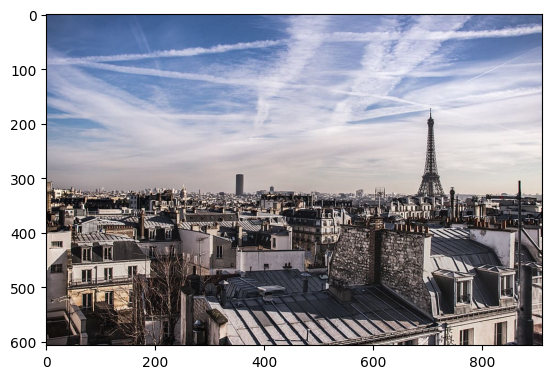

In [5]:
plt.imshow(base)

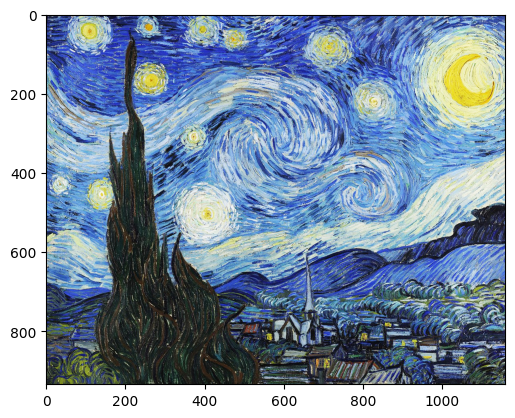

In [6]:
plt.imshow(style)

In [7]:
def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x[0]
    # Remove zero-center by mean pixel

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # 'BGR'->'RGB'
    x = cv.cvtColor(x,cv.COLOR_BGR2RGB)
    x = np.clip(x, 0, 255).astype("uint8")
    x=cv.resize(x,(base.shape[1],base.shape[0]),interpolation=cv.INTER_CUBIC)
    return x

In [8]:
img_nrows=224
img_ncols=224

In [9]:
def gram_matrix(x):

    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * ((combination.shape[-1])**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))/1000


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [10]:
style_layer_names = [
    "block1_conv2",
    "block2_conv2",
    "block3_conv3",
    "block4_conv2",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv3"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    # print('yes')
    # Initialize the loss
    closs = tf.zeros(shape=())
    sloss = tf.zeros(shape=())
    loss = tf.zeros(shape=())
    # print(loss)

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    closs=closs+content_loss(base_image_features, combination_features)
    loss = loss +   content_loss(base_image_features, combination_features)
    # print(tf.reduce_sum((base_image_features- combination_features)**2))
    # print(loss)

    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)/10
        sloss= sloss+(1 / len(style_layer_names)) * sl
        loss += (1 / len(style_layer_names)) * sl
        # print(sl)
    # print('yes')

    # Add total variation loss
    loss +=  1e-7*total_variation_loss(combination_image)
    # print(total_variation_loss(combination_image))

    return loss,closs,sloss

In [11]:
result_prefix='output'

In [12]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss,closs,sloss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)

    return loss, grads,closs,sloss

In [13]:
def apply_avg_pooling(image, pool_size=2, strides=2):
    return tf.nn.avg_pool2d(image, ksize=pool_size, strides=strides, padding='SAME')

def upsample_image(image, original_size):
    return tf.image.resize(image, size=original_size, method=tf.image.ResizeMethod.BILINEAR)

In [24]:
optimizer = tf.keras.optimizers.legacy.Adam(
   keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=10.0, decay_steps=10, decay_rate=0.99
    )
)
base_image =tf.Variable( tf.convert_to_tensor(preprocess_image('/content/neural_style_transfer_5_0.jpg')))
style_reference_image = tf.Variable( tf.convert_to_tensor(preprocess_image('/content/neural_style_transfer_5_1.jpg')))
combination_image = tf.Variable( tf.convert_to_tensor(preprocess_image('/content/neural_style_transfer_5_0.jpg')))

original_size = tf.shape(combination_image)[1:3]

iterations = 1000
for i in range(1, iterations + 1):
    loss,grads,closs,sloss = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )

    optimizer.apply_gradients([(grads, combination_image)])




    if True:
        print("Iteration %d: loss=%.2f" % (i, loss),"content loss=%.2f" % (closs),"style loss=%.2f" % (sloss))


        if(i%501==0):
          pooled_image = apply_avg_pooling(combination_image)
          combination_image.assign(upsample_image(pooled_image, original_size))

        if  i%100==0:

            img1 = deprocess_image(combination_image.numpy())
            fname = result_prefix + "_at_iteration_%d.png" % i
            keras.utils.save_img(fname, img1)


Iteration 1: loss=5463837.00 content loss=0.00 style loss=5463414.00
Iteration 2: loss=2367625.00 content loss=17462.41 style loss=2349674.50
Iteration 3: loss=1188654.00 content loss=31882.25 style loss=1156214.62
Iteration 4: loss=1357263.25 content loss=39015.32 style loss=1317647.88
Iteration 5: loss=1370454.50 content loss=41108.00 style loss=1328736.50
Iteration 6: loss=1091359.75 content loss=41813.92 style loss=1048948.38
Iteration 7: loss=740688.56 content loss=41986.57 style loss=698127.50
Iteration 8: loss=495965.22 content loss=41374.62 style loss=454040.22
Iteration 9: loss=402107.69 content loss=41423.90 style loss=360153.44
Iteration 10: loss=399176.31 content loss=42422.13 style loss=356238.22
Iteration 11: loss=415013.97 content loss=43249.60 style loss=371258.19
Iteration 12: loss=400632.66 content loss=42607.94 style loss=357526.44
Iteration 13: loss=339211.69 content loss=40555.91 style loss=298165.22
Iteration 14: loss=266390.84 content loss=38226.86 style loss=227

In [25]:
styled_image=cv.imread('/content/output_at_iteration_1000.png')
styled_image=cv.cvtColor(styled_image,cv.COLOR_BGR2RGB)

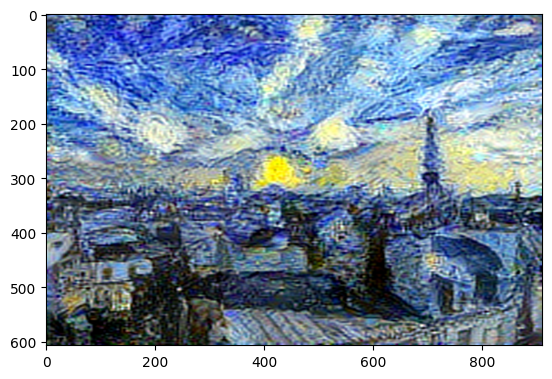

In [26]:
plt.imshow(styled_image)